# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [8]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [9]:
# Read the Mapbox API key
load_dotenv("/Users/sumit/Desktop/New-Repo/.env")
map_box_api = os.getenv("MAPBOX_API_KEY")

px.set_mapbox_access_token(map_box_api)

# Import Data

In [10]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")


file_path1=Path('Data/neighborhoods_coordinates.csv')
neighborhood_cordinates=pd.read_csv(file_path1,delimiter=',')



In [11]:
housing_stats1=sfo_data.groupby(['year']).mean()
housing_stats1.head()
neighborhood_exp=sfo_data.groupby('neighborhood').mean()
neighborhood_exp.sort_values(by='sale_price_sqr_foot', ascending=False,inplace=True)

top_10_expensive = neighborhood_exp.head(10)


- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [12]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    
    housing_units_year=housing_stats1.drop(columns=['sale_price_sqr_foot','gross_rent'])

    housing_units_per_year=housing_units_year.hvplot(
            kind='bar',
                ylim=([350000,390000]),
            title='Average housing units per year'
            )
    return housing_units_per_year


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""

    housing_stats=housing_stats1.drop(columns=['housing_units'])
    avg_monthly_rent=housing_stats.loc[:,'gross_rent']
    average_gross_rent=avg_monthly_rent.plot.line(title='Average monthly rent')
    return average_gross_rent



def average_sales_price():
    """Average Sales Price Per Year."""
    
    
    housing_stats=housing_stats1.drop(columns=['housing_units'])
    avg_sale_price=housing_stats.loc[:,'sale_price_sqr_foot']
    average_sales_price=avg_sale_price.plot.line(title='Average sale price per sqft ')
    return average_sales_price


def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    neighborhood_stats=sfo_data.groupby(['year','neighborhood']).mean()

    average_price_by_neighborhood= neighborhood_stats.hvplot(
        x='year',
        y='sale_price_sqr_foot', 
        groupby='neighborhood',
        kind='line' ,
        dynamic=False)* neighborhood_stats.hvplot(
        x='year', 
        y='gross_rent',
        groupby='neighborhood',
        dynamic=False, 
        kind='line',
        ylabel='Avg. monthly rent')

    return average_price_by_neighborhood   
    




def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
 
    top_most_expensive_neighborhoods=top_10_expensive.sale_price_sqr_foot.hvplot(
        kind='bar',
        x= 'neighborhood',
        title='Top 10 Expensive Neighborhoods in SFO',
        rot=90,
        ylabel='Avg. Sale Price per sqft',
        height=400)
    return top_most_expensive_neighborhoods


def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    
    neighborhood_stats=sfo_data.groupby(['year','neighborhood']).mean()
    top_10_stats=neighborhood_stats.reset_index().drop(columns='housing_units')
    top_10_stats.head()
    most_expensive_neighborhoods_rent_sales=top_10_stats.hvplot(
        x='year',
        groupby='neighborhood',
        dynamic=False,
        kind='bar',
        width=700, 
        height=500,
        rot=90)
    return most_expensive_neighborhoods_rent_sales
    
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""

    neighborhood_mean=sfo_data.groupby('neighborhood').mean().reset_index()
    neighborhood_mean_cordinates=pd.concat([neighborhood_mean,neighborhood_cordinates],         axis='columns',join='inner')
    parallel_coordinates=px.scatter_mapbox(
            neighborhood_mean_cordinates,
            lat= 'Lat',
            lon= 'Lon',
            color='gross_rent',
            hover_name='neighborhood',
            size='sale_price_sqr_foot')
   

    return parallel_coordinates



def parallel_categories():
    """Parallel Categories Plot."""
    
    top_10_parallel=top_10_expensive.reset_index()
    parallel_categories=px.parallel_categories(
        top_10_parallel,
        dimensions=['neighborhood','sale_price_sqr_foot','housing_units','gross_rent'],
        color='sale_price_sqr_foot',
        color_continuous_scale=px.colors.sequential.Inferno
        
        )
    return parallel_categories


def neighborhood_map():
    """Neighborhood Map."""
   
    top_10_parallel=top_10_expensive.reset_index()
    neighborhood_map=px.parallel_coordinates(top_10_parallel,
        dimensions=['sale_price_sqr_foot','housing_units','gross_rent'],
        color='sale_price_sqr_foot',
        color_continuous_scale=px.colors.sequential.Inferno)
    return neighborhood_map
    
   


def sunburst():
    """Sunburst Plot."""
    new=sfo_data.groupby(['neighborhood','year']).mean()
    new22=new.reset_index()
    top_10_expensive.reset_index(inplace=True)
    selected_sunburst=new22.loc[new22.neighborhood.isin(top_10_expensive['neighborhood'])]
    sunburst=px.sunburst(
        selected_sunburst,
        path=['year','neighborhood'],
        values='gross_rent',
        color='gross_rent',
        title='Cost analysis of the most expensive neighborhoods in SFO')
    return sunburst


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [13]:
# Create a Title for the Dashboard

#  Create tabs

# Create a tab layout for the dashboard


# Create the dashboard
# YOUR CODE HERE!

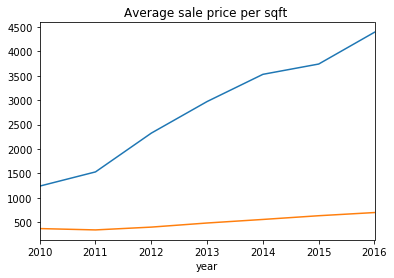

In [14]:
title = pn.panel('## SFO Housing Market Data')

Avg_plot=pn.Column("Housing Trends",housing_units_per_year(),average_gross_rent(),average_sales_price(),average_price_by_neighborhood())

Expensive_plot=pn.Column("Most Expensive Neighborhoods",top_most_expensive_neighborhoods(),
most_expensive_neighborhoods_rent_sales(),sunburst())

Paralell_plots=pn.Column("Comparison",parallel_categories(),parallel_coordinates(),neighborhood_map().show())

SFO_dashboard = pn.Tabs(("Trends", Avg_plot), ("Top_10", Expensive_plot),("Top_10_Comp", Paralell_plots)
)


## Serve the Panel Dashboard

In [15]:
# Serve the# dashboard
SFO_dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] HoloViews(Bars)
        [2] Str(AxesSubplot)
        [3] Str(AxesSubplot)
        [4] Row
            [0] HoloViews(HoloMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
    [1] Column
        [0] Markdown(str)
        [1] HoloViews(Bars)
        [2] Row
            [0] HoloViews(HoloMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
        [3] Plotly(Figure)
    [2] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
        [2] Plotly(Figure)
        [3] Str(None)

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [16]:
housing_units_per_year()

:Bars   [year]   (housing_units)

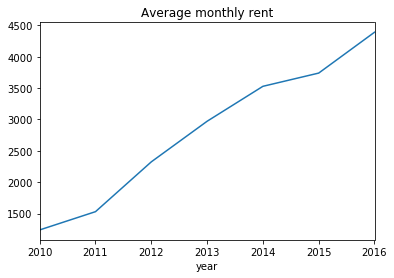

In [17]:
average_gross_rent()

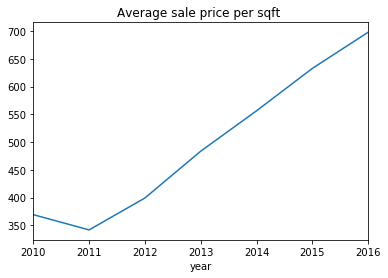

In [18]:
average_sales_price()

In [19]:
average_price_by_neighborhood()

:HoloMap   [neighborhood]
   :Overlay
      .Curve.I  :Curve   [year]   (sale_price_sqr_foot)
      .Curve.II :Curve   [year]   (gross_rent)

In [20]:
top_most_expensive_neighborhoods()

:Bars   [neighborhood]   (sale_price_sqr_foot)

In [21]:
most_expensive_neighborhoods_rent_sales()

:HoloMap   [neighborhood]
   :Bars   [year,Variable]   (value)

In [22]:
neighborhood_map().show()

In [23]:
parallel_categories()

In [24]:
parallel_coordinates()

In [25]:
sunburst()
